In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [28]:
from torch.utils.data import Dataset, DataLoader

#Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (numpy array or list): Input data.
            labels (numpy array or list): Labels corresponding to the data.
            transform (callable, optional): Optional transform to apply to samples.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Fetches a single sample and its label
        sample = self.data[idx]

        # Apply transformations, if any
        if self.transform:
            sample = self.transform(sample)

        # Return the sample and its label
        return sample, sample

In [29]:
# Prepare training data
train_data = np.random.rand(1000, 32, 32)  # 1000 samples, 32x32 dimensions
train_dataset = CustomDataset(train_data)


test_data = np.random.rand(1000, 32, 32)  # 1000 samples, 32x32 dimensions
test_dataset = CustomDataset(test_data)

1000
1000


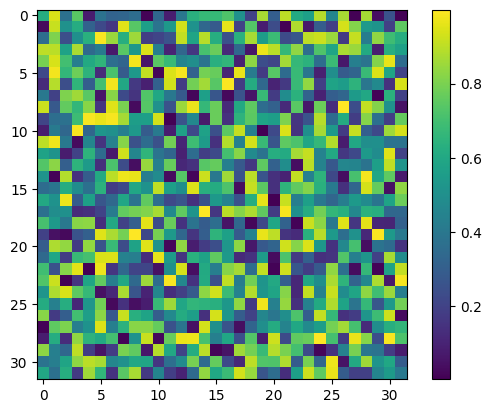

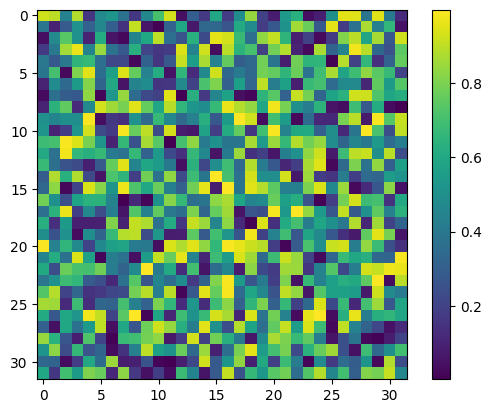

(32, 32)


In [35]:
#check data
print(len(train_dataset))
print(len(test_dataset))

for i in [0, 101]:
    #im = train_dataset[i]
    im, _ = train_dataset[i]  # Extract input (first element of the tuple)

    #plt.imshow(im.numpy()[0])
    plt.imshow(im)

    #plt.title(label)
    plt.colorbar()
    plt.show()

print(im.shape)

In [36]:
from torch.utils.data import DataLoader

# Create DataLoader for batching
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)# estimates mu, log-variance of approximate posterior q(z|x)

    def reparameterize(self, mu, logvar):
        
        # TODO: write some code which returns a random sample from the approximate posterior q(z|x) here
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))# estimates mu of likelihood p(x|z)

    def forward(self, x):
        
        # TODO: write some code which returns
        # 1) mu,log-variance of the approximate posterior given x
        # 2) mu of the likelihood given a random sample from the posterior given x
        print(x.shape)
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        
        return recon, mu, logvar# should return  (likelihood mu, posterior mu, posterior log-variance)
    
model = VAE()

In [ ]:
def loss_function(recon, x, mu, logvar):
    
    # TODO: write some code here to compute the negative ELBO shown above.
    
    # The reconstruction term can be approximated with a single sample from the approximate posterior.
    # Use the analytical exppression for the KL term.
    # recon, mu and logvar are the outputs from model.forward(x).
    
    L2 = torch.sum((recon - x.view(-1, 784))**2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return L2 + 1.0 * KLD

In [47]:
from torch import optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)# this automatically batches up examples, adding a batch dimension
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [48]:
def train(epoch):
    model.train()
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        
        # TODO: write some code here
        # carry out an optimisation step for each batch
        # after each epoch report the average loss over the training dataset
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            
            # TODO: write some code here
            # report the average loss over the test dataset
            
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, 5):
    train(epoch)
    test(epoch)

torch.Size([64, 32, 32])


RuntimeError: shape '[-1, 784]' is invalid for input of size 65536

In [41]:
print(x.shape)


NameError: name 'x' is not defined